<a href="https://colab.research.google.com/github/divyaag123/Twitter-Sentiment-analysis-using-3-machine-models/blob/main/Copy_of_TwitterSEntiment_analysis_4year_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#installing kaggle library
!pip install kaggle

In [11]:
#configure the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [12]:


# API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:

#extracting the compressed dataset

from zipfile import ZipFile
dataset = '/content/sentiment140.zip'


with ZipFile(dataset , 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [14]:
#importing the dependencies
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
#printing stopwords in english
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Data Processing


In [18]:
#loading the data from csv file to pandas dataframe
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv' , encoding = 'ISO-8859-1')

In [19]:
# checking the number of rows and columns
twitter_data.shape

(1599999, 6)

In [20]:
#printing the first five rows of the dataframe
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [21]:
# naming the columns and reading the datset again


column_names = ['target' , 'id' , 'date' , 'flag' ,'user' , 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv' , names = column_names ,encoding = 'ISO-8859-1')



In [22]:
twitter_data.shape

(1600000, 6)

In [23]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [24]:
# counting the no. of missing values in the dataset , replacing the missing values
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [25]:
# understanding the distributtion of target variable
# no. of positive and negative tweets
twitter_data['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [26]:
#so we can see that we have equal distribution
#let's convert the 4 value into 1 , 1 means positive
# all this comes under data preprocessing
twitter_data.replace({'target' : {4:1}} , inplace = True)

In [27]:
twitter_data.replace({'target' : {4: 1} }, inplace = True)

In [28]:
twitter_data['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

In [29]:
# 0 ---> negative Tweet
# 1 ----> positive tweet


In [30]:
# we are going to use the porter stemer function

Stemming ----> it is the process of reducing a word to its root word

In [31]:
port_stem = PorterStemmer()

In [32]:
def stemming(content):

  stemmed_content = re.sub('[^a-zA-Z]' ,' ', content)#anything except the alphabets are removed
  stemmed_content = stemmed_content.lower()#converting to lowercase
  stemmed_content = stemmed_content.split()#spliting all the words in a list and putting them into a tweet
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]# ignoring the stopwords
  stemmed_content = ' '.join(stemmed_content) #combining the tweet

  return stemmed_content


In [33]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming) # 50 min to complete the execution

In [34]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [35]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [36]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [37]:
# model is trying to understand between 1 and positve tweet and 0 and negative tweet
# separating the data and the label(target)
X= twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

In [38]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [39]:
print(Y)

[0 0 0 ... 1 1 1]


In [40]:
# spliting data into training and test data
X_train , X_test , Y_train , Y_test = train_test_split(X , Y , test_size = 0.2 , stratify = Y , random_state = 2)

In [41]:
print(X.shape , X_train.shape , X_test.shape , Y_test.shape)

(1600000,) (1280000,) (320000,) (320000,)


In [42]:
print(X_train  )

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [43]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


Feature Extraction or vectorisation ----> converting the textual data to numerical data

In [44]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [45]:
print(X_train)

  (0, 443066)	0.4484755317023172
  (0, 235045)	0.41996827700291095
  (0, 109306)	0.3753708587402299
  (0, 185193)	0.5277679060576009
  (0, 354543)	0.3588091611460021
  (0, 436713)	0.27259876264838384
  (1, 160636)	1.0
  (2, 288470)	0.16786949597862733
  (2, 132311)	0.2028971570399794
  (2, 150715)	0.18803850583207948
  (2, 178061)	0.1619010109445149
  (2, 409143)	0.15169282335109835
  (2, 266729)	0.24123230668976975
  (2, 443430)	0.3348599670252845
  (2, 77929)	0.31284080750346344
  (2, 433560)	0.3296595898028565
  (2, 406399)	0.32105459490875526
  (2, 129411)	0.29074192727957143
  (2, 407301)	0.18709338684973031
  (2, 124484)	0.1892155960801415
  (2, 109306)	0.4591176413728317
  (3, 172421)	0.37464146922154384
  (3, 411528)	0.27089772444087873
  (3, 388626)	0.3940776331458846
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 390130)	0.22064742191076112
  (1279996, 434014)	0.2718945052332447
  (1279996, 318303)	0.21254698865277746
  (1279996, 237899)	0.2236567560099234
  (1279996, 2910

In [46]:
print(X_test)

  (0, 420984)	0.17915624523539803
  (0, 409143)	0.31430470598079707
  (0, 398906)	0.3491043873264267
  (0, 388348)	0.21985076072061738
  (0, 279082)	0.1782518010910344
  (0, 271016)	0.4535662391658828
  (0, 171378)	0.2805816206356073
  (0, 138164)	0.23688292264071403
  (0, 132364)	0.25525488955578596
  (0, 106069)	0.3655545001090455
  (0, 67828)	0.26800375270827315
  (0, 31168)	0.16247724180521766
  (0, 15110)	0.1719352837797837
  (1, 366203)	0.24595562404108307
  (1, 348135)	0.4739279595416274
  (1, 256777)	0.28751585696559306
  (1, 217562)	0.40288153995289894
  (1, 145393)	0.575262969264869
  (1, 15110)	0.211037449588008
  (1, 6463)	0.30733520460524466
  (2, 400621)	0.4317732461913093
  (2, 256834)	0.2564939661498776
  (2, 183312)	0.5892069252021465
  (2, 89448)	0.36340369428387626
  (2, 34401)	0.37916255084357414
  :	:
  (319994, 123278)	0.4530341382559843
  (319995, 444934)	0.3211092817599261
  (319995, 420984)	0.22631428606830145
  (319995, 416257)	0.23816465111736276
  (319995, 3

# Training the machine learning model ---> Logistic Regression


In [47]:
#model = LogisticRegression(max_iter = 1000)

In [48]:
#model.fit(X_train , Y_train)

Traing the machine learning model ---> Naive Bayes Classifier

In [49]:
# Naive Bayes Classifier
#nb_classifier = MultinomialNB()
#nb_classifier.fit(X_train, Y_train)

Traing the machine learning model ---> Support Vector Classifier

In [50]:
# SVM Classifier
#svm_classifier = LinearSVC()
#svm_classifier.fit(X_train, Y_train)

Traning the machine learning model ---> Random Forest Classifier

In [51]:
# Random Forest Classifier
#rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
#rf_classifier.fit(X_train, Y_train)

Label Encoder

In [52]:
# Encode labels for compatibility with the confusion matrix
le = LabelEncoder()
y_test_encoded = le.fit_transform(Y_test)

In [53]:
# Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()

}

Evaluation Metrics ---->Confusion matrix , heat map , accuracy score

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


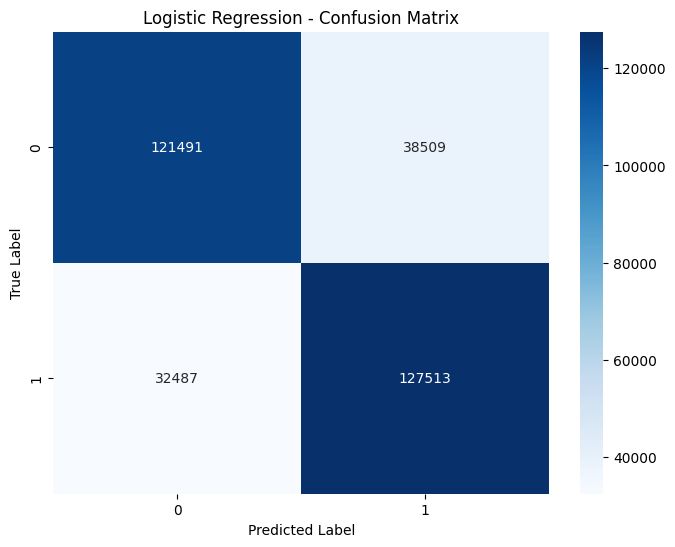

Logistic Regression Accuracy: 0.7781



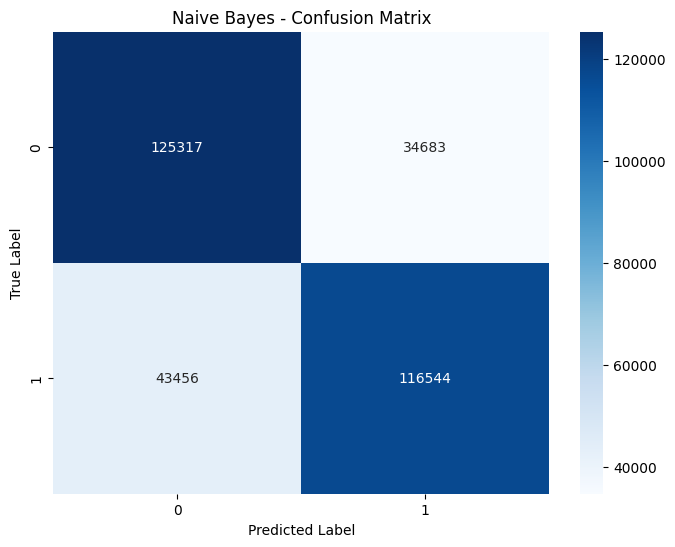

Naive Bayes Accuracy: 0.7558



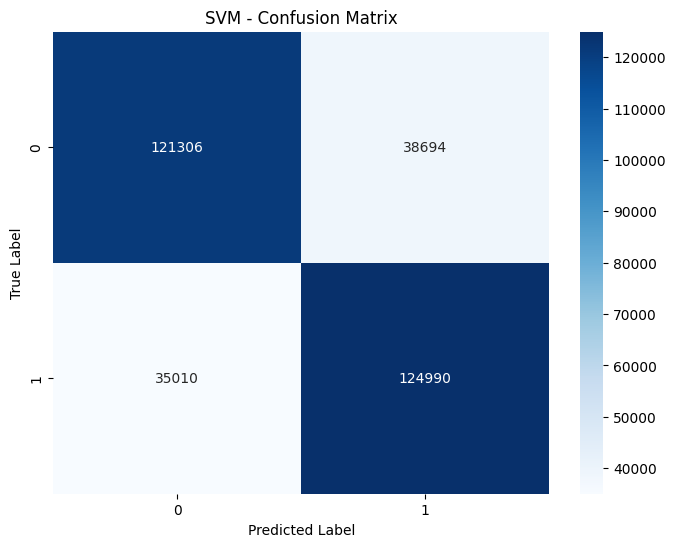

SVM Accuracy: 0.7697



In [54]:
# Confusion Matrix and Heatmap for each model
for name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(Y_test, y_pred)

    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Print accuracy
    accuracy = accuracy_score(Y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}\n")

In [55]:
#there are cases of overfitting where training data accuracy is more and test data accuracy is less




Model Test Accuarcy is 77.8%

Saving the trained model

In [56]:
import pickle

In [57]:
filename = 'trained_model.sav'
pickle.dump(model , open(filename , 'wb'))

Using the saved the model for future predictions

In [59]:
#loading the saved model
loaded_model = pickle.load(open('/content/trained_model.sav' , 'rb'))

In [60]:
X_new = X_test[200]
print(Y_test[200])

prediction = model.predict(X_new)
print(prediction)

if(prediction[0] == 0):
  print('Negative Tweet')
else:
  print('Positve Tweet')

1
[1]
Positve Tweet


In [61]:
X_new = X_test[3]
print(Y_test[3])

prediction = model.predict(X_new)
print(prediction)

if(prediction[0] == 0):
  print('Negative Tweet')
else:
  print('Positve Tweet')

0
[0]
Negative Tweet
